In [1]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

bank_data = pd.read_csv('bank-additional-full.csv')

C:\Users\Milos\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Handling categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome', 'y']
bank_data_tran = pd.get_dummies(bank_data, columns = categorical_features, drop_first=True)

bank_data_tran.drop(['duration'], axis = 1, inplace = True)
#bank_data_tran.drop(['job_blue-collar', 'job_self-employed', 'job_services', 'job_unemployed', 'day_of_week_mon'], axis = 1, inplace = True)

#because of the high correlation coefficient between euribor3m rate and nr. of employed, the latter is going to be dropped
bank_data_tran.drop(['nr.employed'], axis = 1, inplace = True)

#apllying the same logic, emp.var.rate is going to be dropped
bank_data_tran.drop(['emp.var.rate'], axis = 1, inplace = True)

In [3]:
#Data preprocessing and splitting and scaling
x = bank_data_tran.iloc[:,bank_data_tran.columns != 'y_yes'].values
y = bank_data_tran.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

In [4]:
sm = SMOTE(random_state=12, ratio = 1.0, k_neighbors = 5)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [5]:
#Function for printing results
def print_results(x_input, true_output, predicted_output, classifier):
    precision, recall, thresholds = precision_recall_curve(true_output, classifier.predict_proba(x_input)[:,1])
    area = auc(recall, precision)
    print("\nArea under precission-recall is:", area)
    
    print("Validation set predictions: \n\n" + classification_report(true_output,predicted_output))
    print("\n Confusion matrix:\n " , confusion_matrix(true_output, predicted_output))
    print("\n")
    print("True negatives:", confusion_matrix(true_output, predicted_output)[0][0])
    print("False positives:", confusion_matrix(true_output, predicted_output)[0][1])
    print("False negatives:", confusion_matrix(true_output, predicted_output)[1][0])
    print("True positives: ", confusion_matrix(true_output, predicted_output)[1][1])

# Decision trees
- <h4> Model training </h4> 

In [6]:
#Decision tree algorithm

td_classifier = DecisionTreeClassifier(criterion='entropy', random_state = 0, splitter = 'best')
td_classifier.fit(x_train_res, y_train_res)

predictions_DT_val = td_classifier.predict(x_val)

print_results(x_val, y_val, predictions_DT_val, td_classifier)


Area under precission-recall is: 0.3608060856142112
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.91      0.90      0.90      5841
          1       0.30      0.34      0.32       749

avg / total       0.84      0.83      0.84      6590


 Confusion matrix:
  [[5233  608]
 [ 491  258]]


True negatives: 5233
False positives: 608
False negatives: 491
True positives:  258


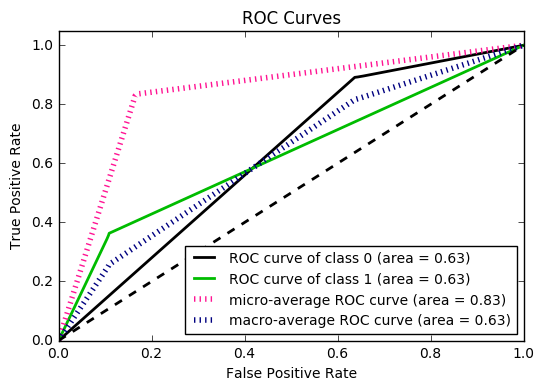

In [10]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_val
y_probas = td_classifier.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

- <h4> Model testing 

In [7]:
predictions_DT_test = td_classifier.predict(x_test)
print_results(x_test, y_test, predictions_DT_test, td_classifier)


Area under precission-recall is: 0.341254205663708
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.91      0.91      0.91      7319
          1       0.29      0.31      0.30       919

avg / total       0.84      0.84      0.84      8238


 Confusion matrix:
  [[6624  695]
 [ 631  288]]


True negatives: 6624
False positives: 695
False negatives: 631
True positives:  288


# Ada Boost - Decision Trees
- <h4> Model training

In [8]:
#Boosting - AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                         algorithm = "SAMME",
                         n_estimators=200)
                         
ada.fit(x_train_res, y_train_res)
predictions_ada = ada.predict(x_val)

print_results(x_val, y_val, predictions_ada, ada)


Area under precission-recall is: 0.3729376904362772
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      5841
          1       0.49      0.33      0.39       749

avg / total       0.87      0.89      0.87      6590


 Confusion matrix:
  [[5587  254]
 [ 503  246]]


True negatives: 5587
False positives: 254
False negatives: 503
True positives:  246


- <h4> Model testing

In [11]:
predictions_ada_test = ada.predict(x_test)
print_results(x_test, y_test, predictions_ada_test, ada)


Area under precission-recall is: 0.35603373842821867
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      7319
          1       0.46      0.30      0.37       919

avg / total       0.87      0.88      0.87      8238


 Confusion matrix:
  [[7000  319]
 [ 642  277]]


True negatives: 7000
False positives: 319
False negatives: 642
True positives:  277


# Gradient Boosting
- <h4> Model training

In [24]:
#Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gradientBoost = GradientBoostingClassifier(n_estimators=100, random_state=1)
gradientBoost.fit(x_train_res, y_train_res)

gradient_predictions = gradientBoost.predict(x_val)

#Results
print_results(x_val, y_val, gradient_predictions, gradientBoost)


Area under precission-recall is: 0.4681621033878043
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.96      0.94      5841
          1       0.54      0.40      0.46       749

avg / total       0.88      0.89      0.89      6590


 Confusion matrix:
  [[5582  259]
 [ 450  299]]


True negatives: 5582
False positives: 259
False negatives: 450
True positives:  299


- <h4> Model testing

In [ ]:
predictions_GradB_test = gradientBoost.predict(x_test)
print_results(x_test, y_test, predictions_GradB_test, classifier=gradientBoost)

# Bagging - Decision Trees
- <h4> Model training

In [25]:
#Bagging with decission trees
from sklearn.ensemble import BaggingClassifier
bagg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=100, random_state=7)
bagg.fit(x_train_res, y_train_res)

predictions_bag = bagg.predict(x_val)

#Results
print_results(x_val, y_val, predictions_bag, bagg)


Area under precission-recall is: 0.42986021945119174
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.95      0.94      5841
          1       0.50      0.38      0.43       749

avg / total       0.87      0.89      0.88      6590


 Confusion matrix:
  [[5556  285]
 [ 468  281]]


True negatives: 5556
False positives: 285
False negatives: 468
True positives:  281


- <h4> Model testing

In [ ]:
predictions_bagg_test = bagg.predict(x_test)
print_results(x_test, y_test, predictions_bagg_test, bagg)

# Random Forest Classifier
- <h4> Model training

In [11]:
#Random Forest Classification Algorithm

# Fitting Random Forest Classification to the Training set
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(x_train_res, y_train_res)

# Predicting the Test set results
predictions_RF_val = rf_classifier.predict(x_val)

#print(classifier.feature_importances_ )

#Results
print_results(x_val, y_val, predictions_RF_val, rf_classifier)

#predictions_RF_test = classifier.predict(x_test)
#print("Test predictions:\n\n " + classification_report(y_test, predictions_RF_test))


Area under precission-recall is: 0.43393971992403335
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      5841
          1       0.53      0.32      0.40       749

avg / total       0.87      0.89      0.88      6590


 Confusion matrix:
  [[5630  211]
 [ 507  242]]


True negatives: 5630
False positives: 211
False negatives: 507
True positives:  242


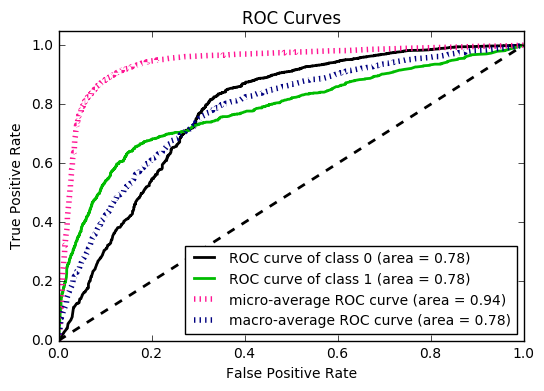

In [12]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_val
y_probas = rf_classifier.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

- <h4> Model testing

In [13]:
predictions_RF_test = rf_classifier.predict(x_test)
print_results(x_test, y_test, predictions_RF_test, rf_classifier)

NameError: name 'rf_classifier' is not defined

In [13]:
# Feature Scaling
sc = StandardScaler()
x_train_res = sc.fit_transform(x_train_res)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# Logistic Regression Classifier
- <h4> Model training

In [9]:
#Logistic Regression Algorithm

logdown = LogisticRegression()
logdown.fit(x_train_res, y_train_res)
predictions_LR = logdown.predict(x_val)

#print("Coefficients: ",  logdown.coef_)

print_results(x_val, y_val, predictions_LR, logdown)


Area under precission-recall is: 0.4507172572916807
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.83      0.88      5841
          1       0.32      0.65      0.43       749

avg / total       0.88      0.81      0.83      6590


 Confusion matrix:
  [[4829 1012]
 [ 265  484]]


True negatives: 4829
False positives: 1012
False negatives: 265
True positives:  484


- <h4> Model testing

In [10]:
predictions_LR_test = logdown.predict(x_test)
print_results(x_test, y_test, predictions_LR_test, logdown)


Area under precission-recall is: 0.4239112527810533
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.84      0.89      7319
          1       0.33      0.63      0.44       919

avg / total       0.88      0.82      0.84      8238


 Confusion matrix:
  [[6152 1167]
 [ 339  580]]


True negatives: 6152
False positives: 1167
False negatives: 339
True positives:  580


# Support Vector Machines
- <h4> Model training

In [ ]:
#SVM algorithm

svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(x_train_res, y_train_res)

predictions_SVC_val = svm_classifier.predict(x_val)

#print_results(x_val, y_val, predictions_SVC_val, svm_classifier)
print("Validation set predictions: \n\n" + classification_report(y_val,predictions_SVC_val))
print("\n Confusion matrix:\n " , confusion_matrix(y_val, predictions_SVC_val))
print("True negatives:", confusion_matrix(y_val, predictions_SVC_val)[0][0])
print("False positives:", confusion_matrix(y_val, predictions_SVC_val)[0][1])
print("False negatives:", confusion_matrix(y_val, predictions_SVC_val)[1][0])
print("True positives: ", confusion_matrix(y_val, predictions_SVC_val)[1][1])

#predictions_SVC_test = svm_classifier.predict(x_test)
#print("Test set predictions:\n\n" + classification_report(y_test, predictions_SVC_test))

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_val
y_probas = svm_classifier.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

- <h4> Model testing

In [ ]:
predictions_SVC_test = svm_classifier.predict(x_test)
print_results(x_test, y_test, predictions_SVC_test, svm_classifier)

# K - nearest neighbours
- <h4> 
Model training (parameters adjusting)

In [16]:
#KNN Algorithm
#adjusting parameters for KNN
error_rate = []

# Will take some time
for i in range(1,20):  
    knn_classifier = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p = 2)
    knn_classifier.fit(x_train_res, y_train_res)
    pred_i = knn_classifier.predict(x_val)
    error_rate.append(np.mean(pred_i != y_val))

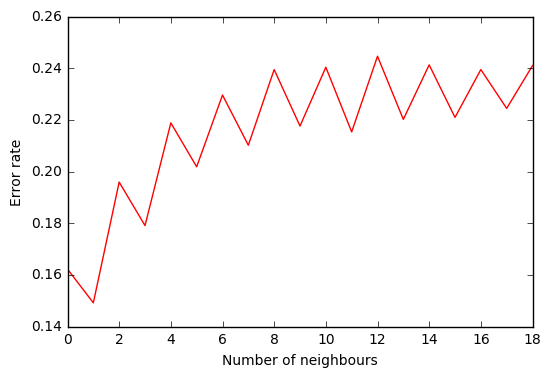

In [17]:
plt.xlabel("Number of neighbours")
plt.ylabel("Error rate")
plt.plot(error_rate, "r")

In [18]:
#From the plot above, we can see that the error_rate is smallest when number of neighbours is 1, so we take that N value
knn_classifier = KNeighborsClassifier(n_neighbors=1, metric = 'minkowski', p = 2)
knn_classifier.fit(x_train_res, y_train_res)
pred_i = knn_classifier.predict(x_val)

#Results
print_results(x_val, y_val, pred_i, knn_classifier)


Area under precission-recall is: 0.36706306075829753
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      5841
          1       0.31      0.35      0.33       749

avg / total       0.85      0.84      0.84      6590


 Confusion matrix:
  [[5259  582]
 [ 487  262]]


True negatives: 5259
False positives: 582
False negatives: 487
True positives:  262


- <h4> Model testing

In [ ]:
predictions_KNN_test = knn_classifier.predict(x_test)
print_results(x_test, y_test, predictions_KNN_test, knn_classifier)

# Gaussian Naive Bayes Classifier
- <h4> Model training

In [19]:
# Gaussian Naive Bayes
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train_res, y_train_res)
#print(gaussian_classifier)
# make predictions
predicted = gaussian_classifier.predict(x_val)
# summarize the fit of the model

print_results(x_val, y_val, predicted, gaussian_classifier)


Area under precission-recall is: 0.4296292246208827
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.90      0.91      5841
          1       0.37      0.48      0.42       749

avg / total       0.87      0.85      0.86      6590


 Confusion matrix:
  [[5247  594]
 [ 393  356]]


True negatives: 5247
False positives: 594
False negatives: 393
True positives:  356


- <h4> Model testing

In [14]:
nb_predictions_test = gaussian_classifier.predict(x_test)
print_results(x_test, y_test, nb_predictions_test, gaussian_classifier)

NameError: name 'gaussian_classifier' is not defined